In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install spafe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython.display as ipd
import librosa.display
import pandas as pd
import soundfile as sf
from pathlib import Path

In [ ]:

# directories
real_audio_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL'
fake_audio_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE'

# Function to load audio files and convert them to a consistent sample rate
def load_audio_files(directory, sample_rate=22050):
    audio_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            path = os.path.join(directory, filename)
            audio, sr = librosa.load(path, sr=sample_rate)
            audio_files.append(audio)
    return audio_files

real_audios = load_audio_files(real_audio_dir)

In [ ]:
fake_audios = load_audio_files(fake_audio_dir)

In [ ]:
print(f"Total number of real audios :{len(real_audios)}")
print(f"Total number of fake audios :{len(fake_audios)}")


Total number of real audios :8
Total number of fake audios :56


A waveform is a two dimensional representation of a sound. The two dimensions in a waveform display are time and intensity.Waveforms are also known as time domain representations of sound as they are representations of changes in intensity over time.

The intensity dimension actually displays sound pressure. Sound pressure is a measure of the tiny variations in air pressure that we are able to perceive as sound. The greater the change in pressure, the louder the sound that we hear.

ref :https://www.mq.edu.au/about/about-the-university/our-faculties/medicine-and-health-sciences/departments-and-centres/department-of-linguistics/our-research/phonetics-and-phonology/speech/acoustics/speech-waveforms/the-waveforms-of-speech

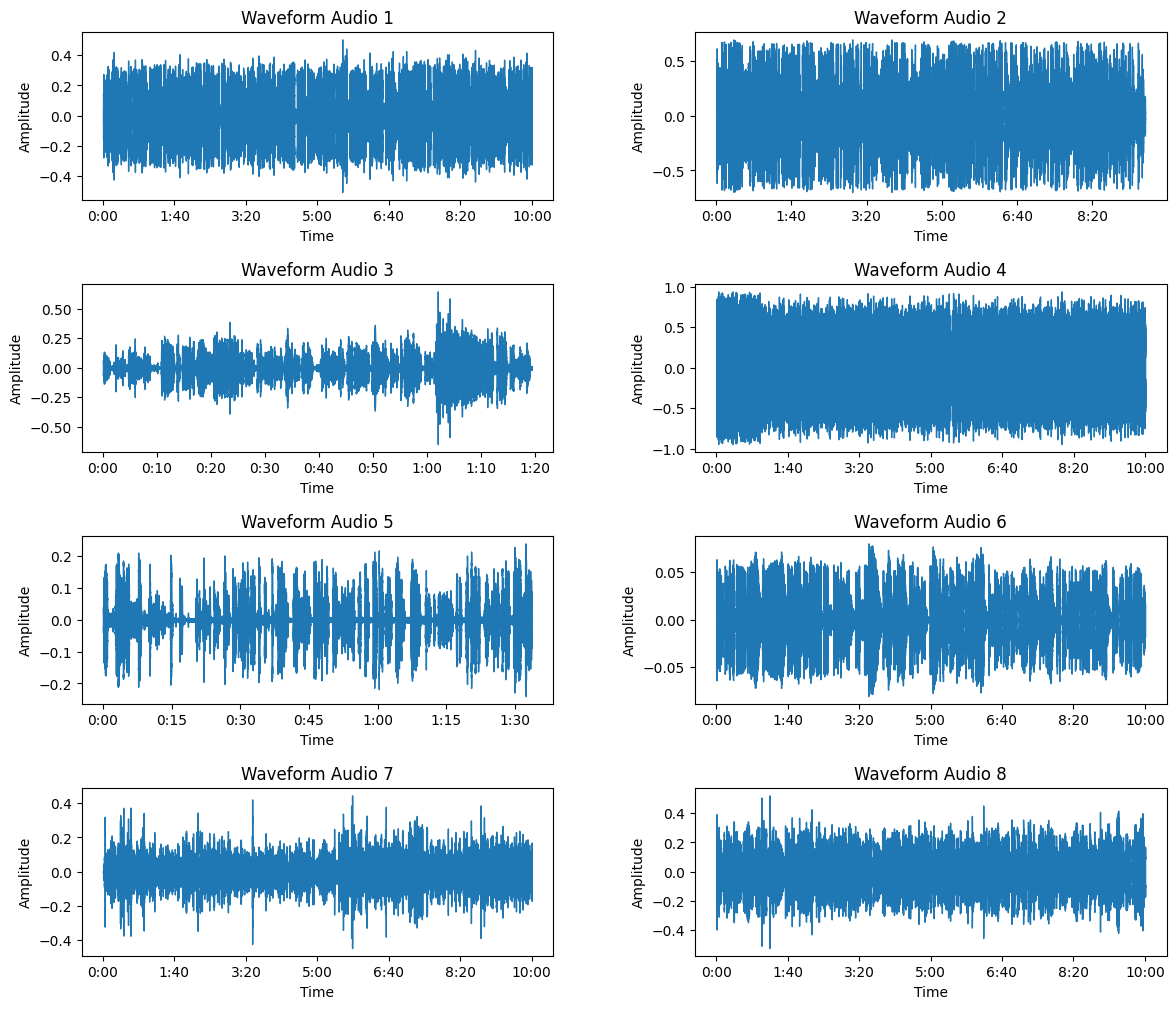

In [ ]:
def plot_waveforms(audio_list, sample_rate, n_cols=2):
    n_rows = (len(audio_list) + n_cols - 1) // n_cols  # Calculate the required number of rows based on the number of audios
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3))  # Adjust the figure size
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust the spacing

    axes = axes.flatten()  # Flatten the axes array for easier iteration if 2D

    for i, audio in enumerate(audio_list):
        librosa.display.waveshow(audio, sr=sample_rate, ax=axes[i])
        axes[i].set_title(f'Waveform Audio {i+1}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Amplitude')

    # Hide any unused axes if the number of audios is less than the number of subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.show()

# waveforms real audios
plot_waveforms(real_audios, sample_rate=22050)

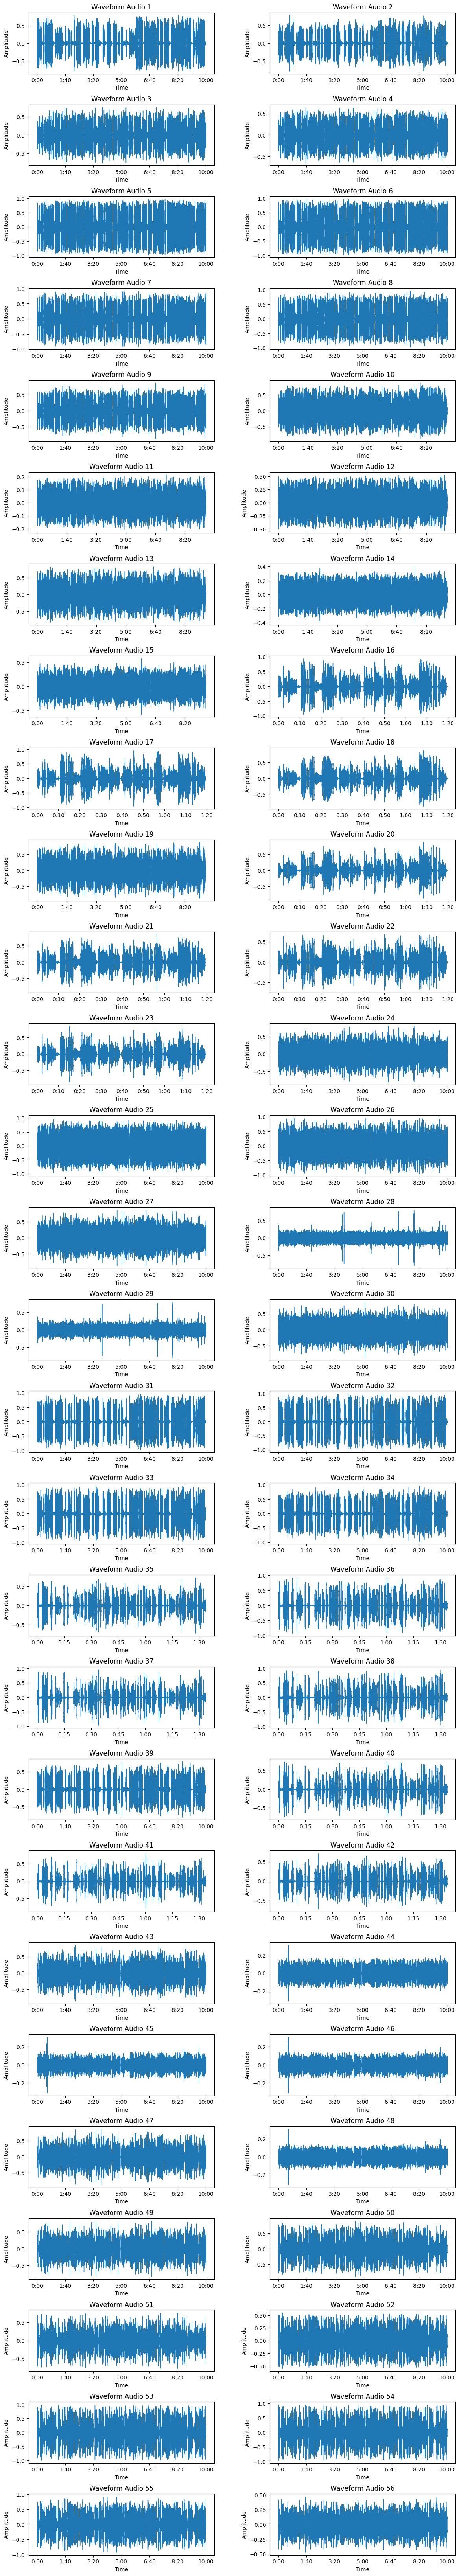

In [ ]:
#waveform fakeaudios
plot_waveforms(fake_audios, sample_rate=22050)

From the waveplots it appears that fake audios have comparatively higher intensity than the real audios.

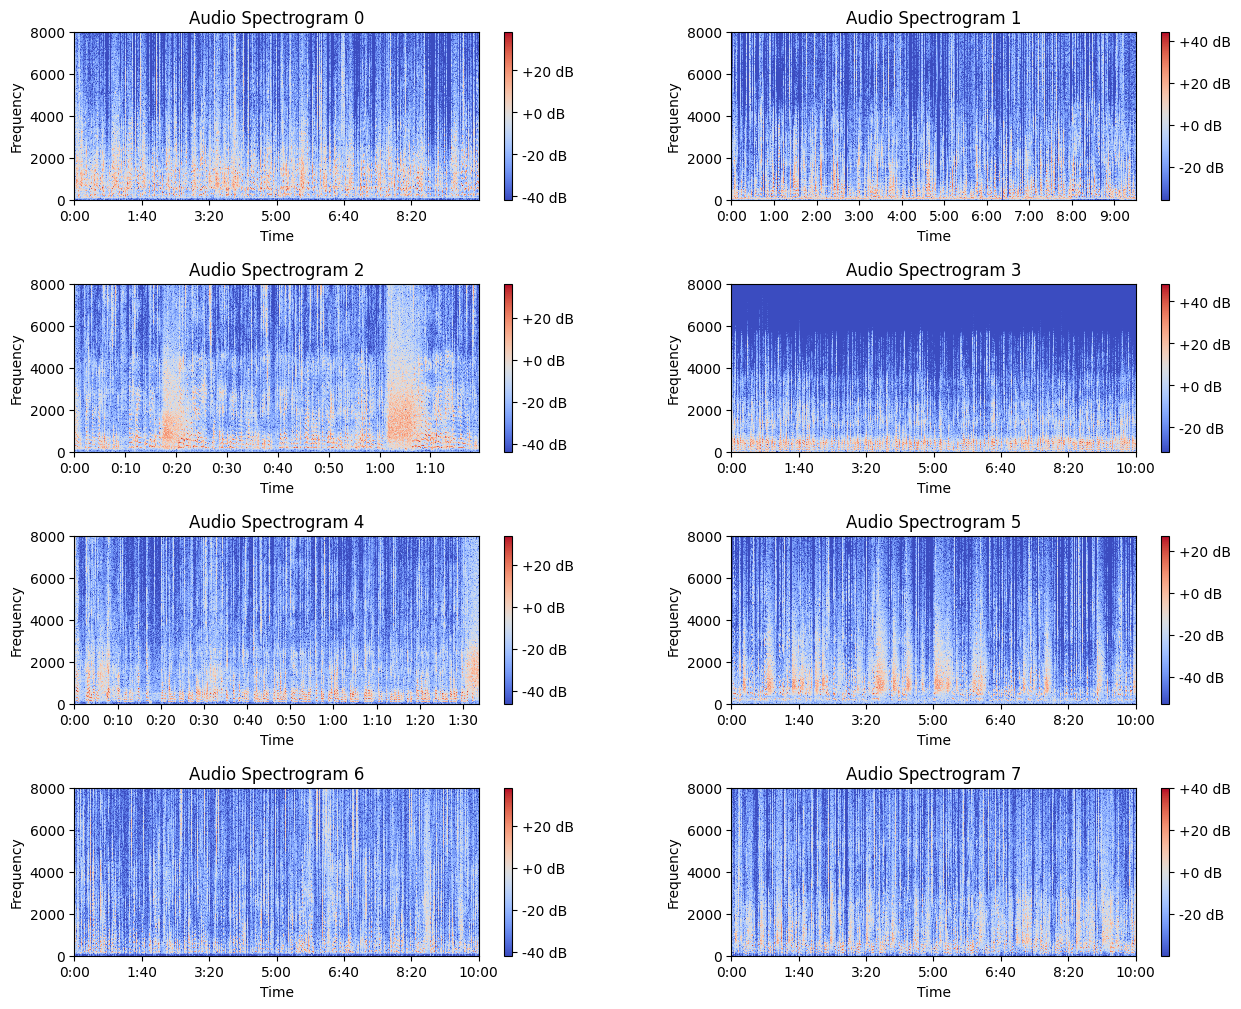

In [ ]:
def plot_spectrograms(audio_list, sample_rate, titles, fmax=8000, n_cols=2):
    n_rows = (len(audio_list) + n_cols - 1) // n_cols  # Calculate the required number of rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for i, audio in enumerate(audio_list):
        X = librosa.stft(audio) ## short term Fourier transform
        Xdb = librosa.amplitude_to_db(abs(X)) #Converting amplitude to db
        img = librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz', cmap='coolwarm', fmax=fmax, ax=axes[i])
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Frequency')
        axes[i].set_ylim(0, fmax)
        fig.colorbar(img, ax=axes[i], format="%+2.0f dB")

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.show()

#  titles
titles = [f'Audio Spectrogram {i}' for i in range(len(real_audios))]

# Example usage with real audios
plot_spectrograms(real_audios, 22050, titles)

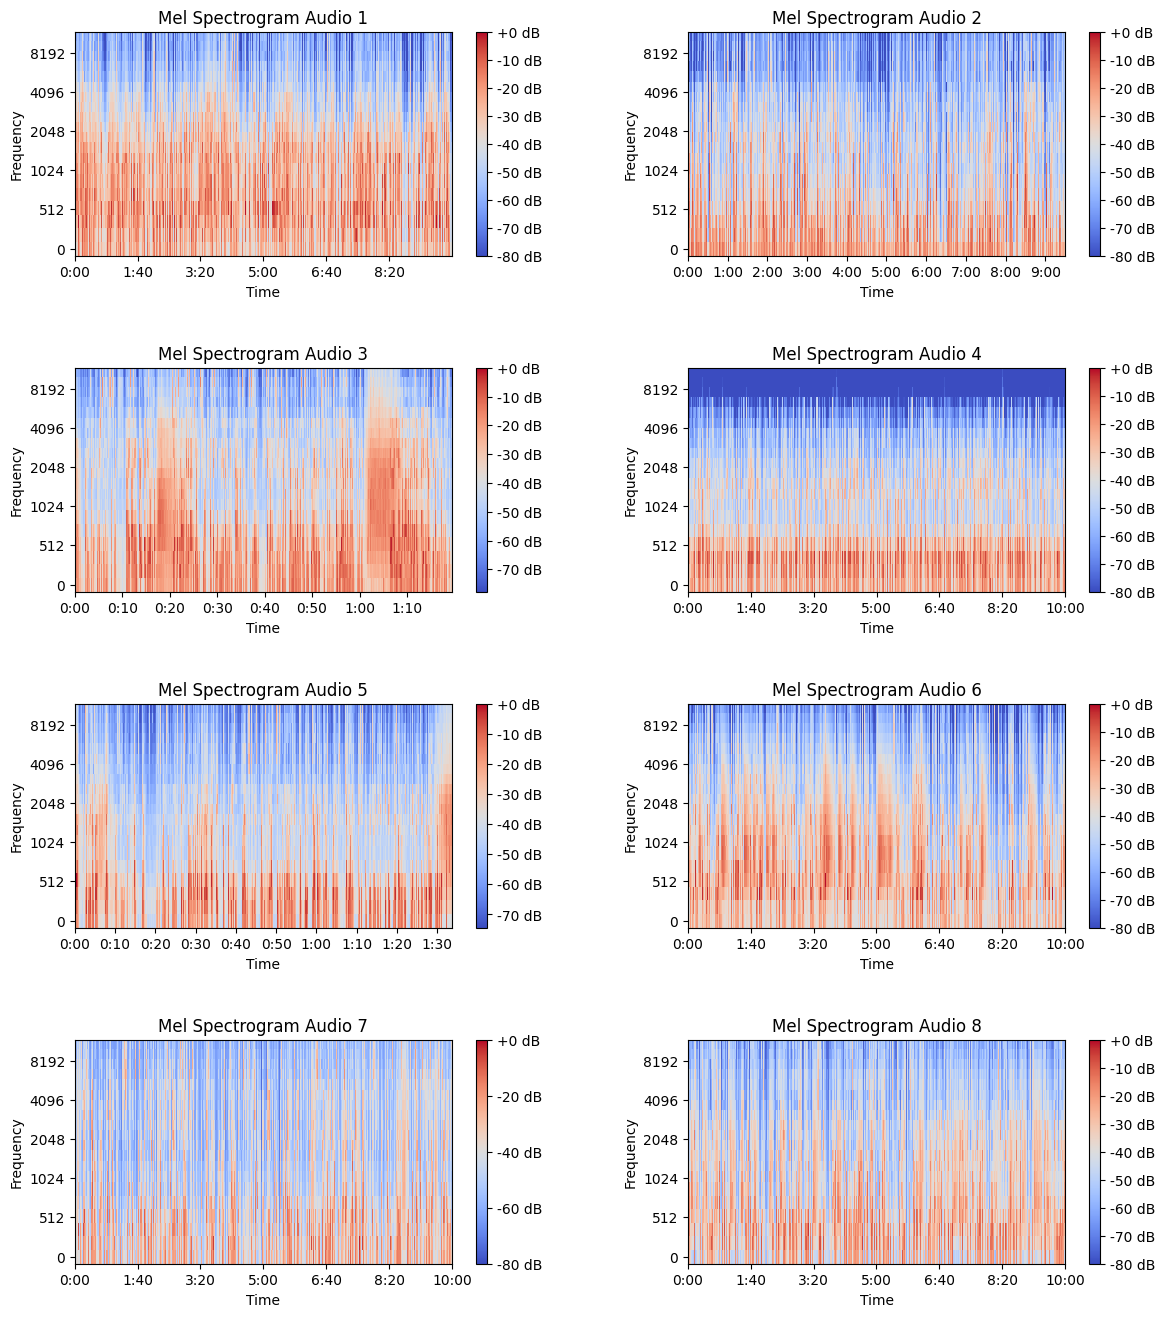

In [ ]:
def plot_mel_spectrograms(audio_list, sample_rate, n_cols=2):
    n_rows = (len(audio_list) + n_cols - 1) // n_cols  # Calculate the required number of rows based on the number of audios
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))  # Adjust figure size
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # spacing between plots

    axes = axes.flatten()  # Flatten the axes array for easier iteration if 2D

    for i, audio in enumerate(audio_list):
        # mel spectrogram
        S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=20)
        S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to db  for visualization

        # Plotting
        img = librosa.display.specshow(S_dB, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel', ax=axes[i], cmap='coolwarm')
        axes[i].set_title(f'Mel Spectrogram Audio {i+1}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Frequency')
        fig.colorbar(img, ax=axes[i], format='%+2.0f dB')


    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.show()


plot_mel_spectrograms(real_audios, sample_rate=22050)

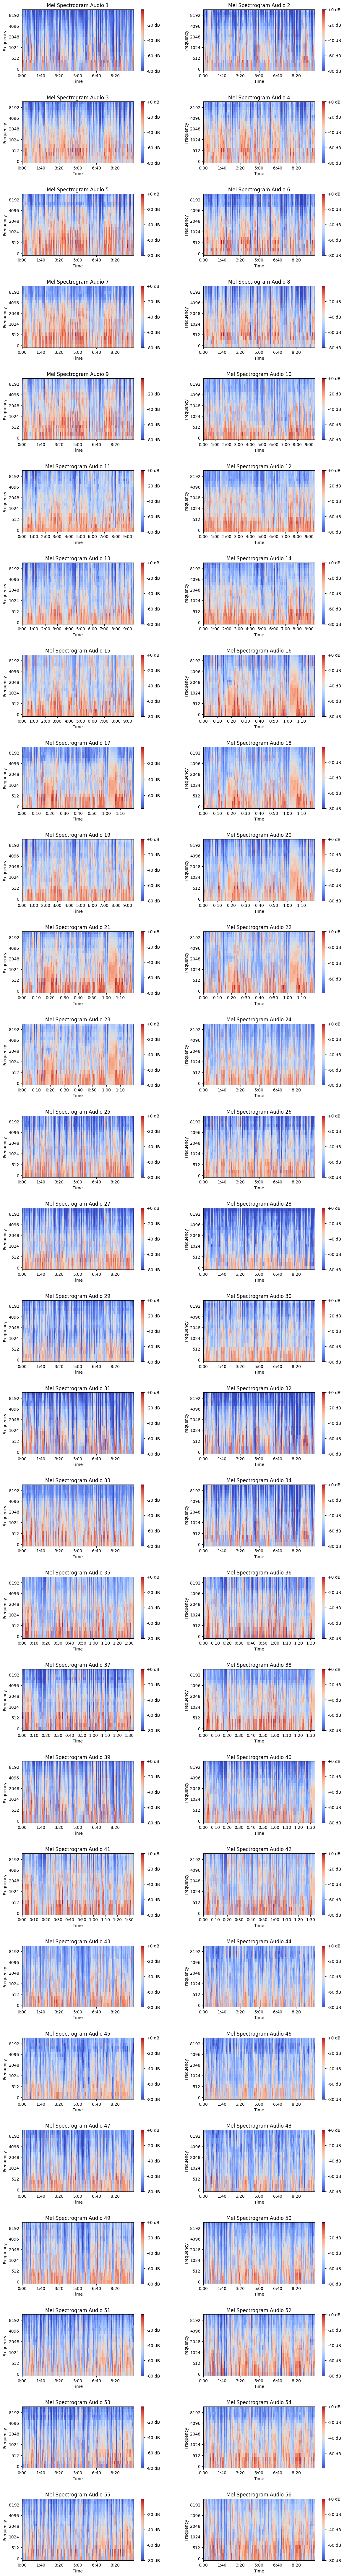

In [ ]:
plot_mel_spectrograms(fake_audios, sample_rate=22050)

In [ ]:
# slicing longer clips to shorter clips to 1 second for feature extraction:


def slice_audio(audio, window_length=1, sr=22050):
    # Window length = 1 sec
    sample_length = window_length * sr
    return [audio[i:i+sample_length] for i in range(0, len(audio), sample_length) if len(audio[i:i+sample_length]) == sample_length]

# Slicing real and fake audio samples
real_slices = [slice for audio in real_audios for slice in slice_audio(audio, window_length=1)]
fake_slices = [slice for audio in fake_audios for slice in slice_audio(audio, window_length=1)]

In [ ]:
ipd.Audio(real_slices[0], rate=22050)

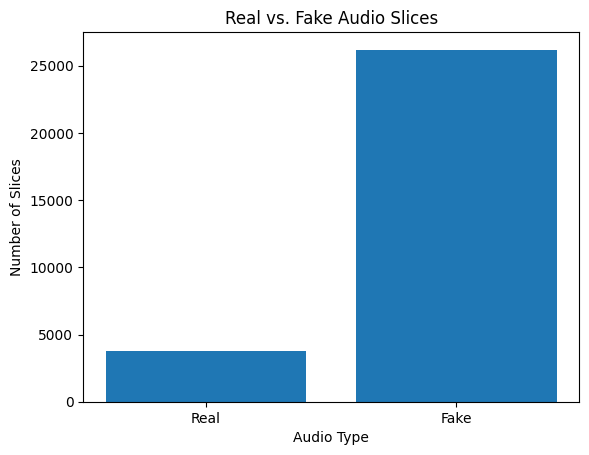

In [ ]:
plt.bar(['Real', 'Fake'], [len(real_slices), len(fake_slices)])
plt.xlabel('Audio Type')
plt.ylabel('Number of Slices')
plt.title('Real vs. Fake Audio Slices')
plt.show()

In [ ]:
ipd.Audio(fake_slices[0], rate=22050)

In [ ]:
os.getcwd()

'/content'

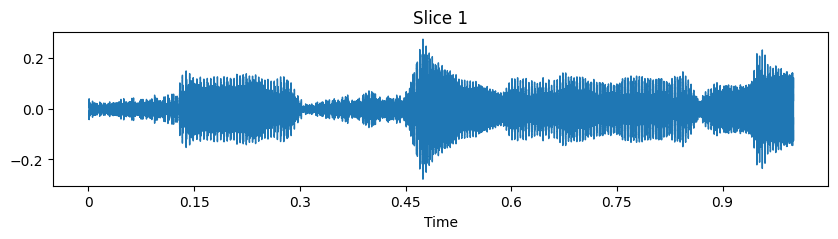

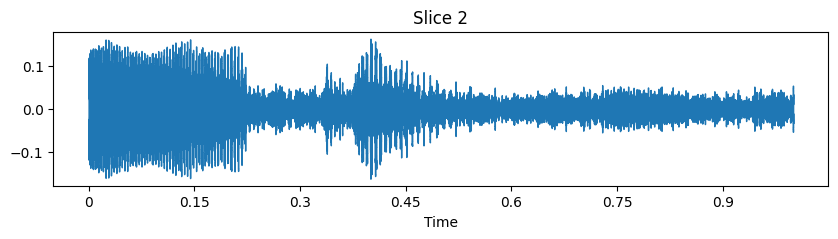

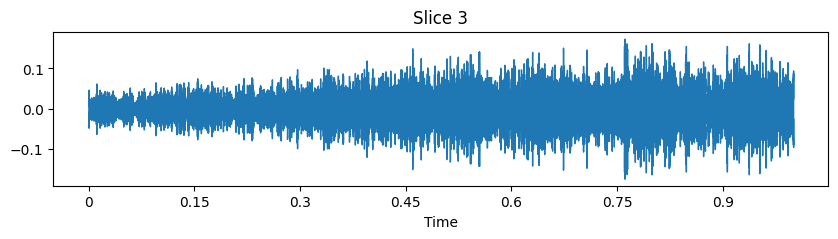

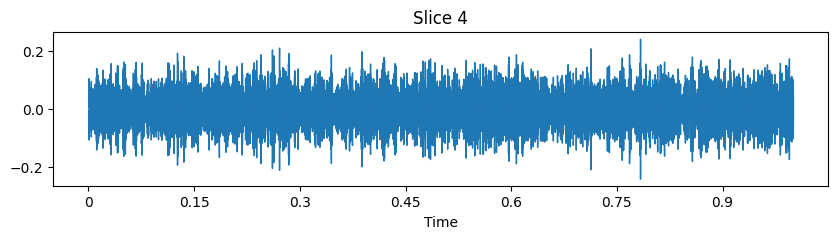

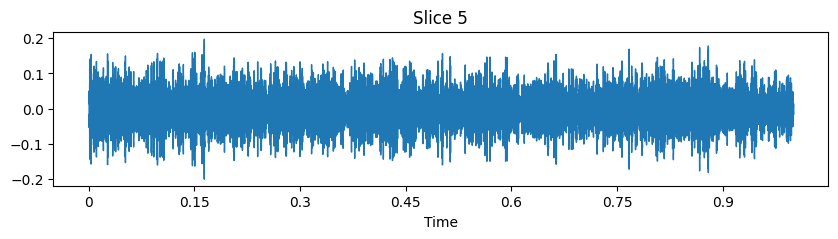

In [ ]:
def plot_and_play(audio_slices, sample_rate=22050):
    for i, audio_slice in enumerate(audio_slices):
        plt.figure(figsize=(10, 2))
        librosa.display.waveshow(audio_slice, sr=sample_rate)
        plt.title(f'Slice {i+1}')
        plt.show()
        display(ipd.Audio(audio_slice, rate=sample_rate))

# Example usage with the first 5 slices of real audio
plot_and_play(real_slices[:5], sample_rate=22050)

In [ ]:
print (f"Total number of 1 second clips for real audios is {len(real_slices)}")
print (f"Total number of 1 second clips for fake audios is {len(fake_slices)}")


Total number of 1 second clips for real audios is 3742
Total number of 1 second clips for fake audios is 26194


In [ ]:
def time_shift(audio, shift_max, sr):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(audio, shift)

# Apply time shift
real_augmented = [time_shift(audio, 1000, 22050) for audio in real_slices]


In [ ]:
len(real_augmented)

3742

In [ ]:
ipd.Audio(real_augmented[0], rate=22050)

In [ ]:


#  pitch shift
real_augmented += [librosa.effects.pitch_shift(audio, sr=22050, n_steps=4) for audio in real_slices]


In [ ]:
ipd.Audio(real_slices[-1] , rate=22050)

In [ ]:
len(real_augmented)

7484

In [ ]:

#  time strech
real_augmented += [librosa.effects.time_stretch(audio,rate =  1.5) for audio in real_slices]

In [ ]:
len(real_augmented)

11226

In [ ]:
ipd.Audio(real_slices[-1] , rate=22050)

# **Feature Extraction**

In [ ]:
#combining real audios with the augmented audios
final_real = real_augmented + real_slices

In [ ]:
len(final_real)

14968

In [ ]:
final_real

[array([-0.0262215 , -0.02084678, -0.01351071, ..., -0.00996742,
        -0.01945952, -0.02658372], dtype=float32),
 array([0.01705249, 0.01280421, 0.00916145, ..., 0.01976361, 0.02054098,
        0.01940471], dtype=float32),
 array([0.03293435, 0.05180843, 0.07549892, ..., 0.00823398, 0.02245408,
        0.02813981], dtype=float32),
 array([ 0.01209346,  0.02984696,  0.03208749, ..., -0.08698164,
        -0.05806322, -0.02165936], dtype=float32),
 array([0.06974051, 0.08279882, 0.07653791, ..., 0.02094961, 0.03138657,
        0.04517532], dtype=float32),
 array([ 0.02840387,  0.03317163,  0.03997565, ..., -0.00466468,
         0.00990709,  0.01978129], dtype=float32),
 array([0.05483009, 0.06200905, 0.05819963, ..., 0.01644658, 0.02492244,
        0.0395233 ], dtype=float32),
 array([-0.1048491 , -0.09430362, -0.08146199, ..., -0.11861227,
        -0.12108932, -0.1144191 ], dtype=float32),
 array([-0.09402794, -0.09016486, -0.0831379 , ..., -0.11035421,
        -0.10885173, -0.1019246

In [ ]:
#feature extraction and dataframe creation
sr = 22050
def extract_audio_features(files):
    features_list = []

    # Iterate over all files
    for y in files:
        # Extract features
        # Chromagram
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()

        # Root Mean Square Energy
        rms = librosa.feature.rms(y=y).mean()

        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

        # Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

        # Mel-Frequency Cepstral Coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).mean(axis=1)

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()

        # Concatenate features as values for dataframe
        features = np.hstack((
            chroma_stft, rms, spectral_centroid, spectral_bandwidth, rolloff, zero_crossing_rate,
            mfccs, spectral_contrast
        ))

        features_list.append(features)

    # Create  DataFrame
    feature_names = [
        'chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate'
    ] + [f'mfcc{i+1}' for i in range(mfccs.shape[0])] + ['spectral_contrast']

    df = pd.DataFrame(features_list, columns=feature_names)

    return df

##real + augmented audio features
audio_features_df = extract_audio_features(final_real)

# Display the DataFrame
print(audio_features_df)

       chroma_stft       rms  spectral_centroid  spectral_bandwidth  \
0         0.275288  0.045092        1738.300516         1707.138985   
1         0.402192  0.030271        2145.587886         1855.629452   
2         0.444117  0.037623        1845.551653         1575.221010   
3         0.514603  0.055094        1789.470637         1476.508964   
4         0.501559  0.046054        1722.545602         1516.182694   
...            ...       ...                ...                 ...   
14963     0.371610  0.049087        2529.072575         2409.970562   
14964     0.380453  0.032703        2666.514180         2112.847586   
14965     0.317955  0.036571        2310.894483         2100.396248   
14966     0.417653  0.041490        1943.153338         1824.786318   
14967     0.401598  0.037857        2042.405086         1803.789276   

           rolloff  zero_crossing_rate       mfcc1       mfcc2       mfcc3  \
0      2999.477317            0.096746 -272.941437  117.712288  -58.6

In [ ]:
#save the data frame as a csv containing the features of the real audios
filepath = Path('/content/drive/My Drive/TMU MSC/MRP/real.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
audio_features_df.to_csv(filepath, index = False)

In [ ]:
#extracting features from the fake audios

fake_features_df = extract_audio_features(fake_slices)

print(fake_features_df)

       chroma_stft       rms  spectral_centroid  spectral_bandwidth  \
0         0.379445  0.061461        2934.226849         2520.786961   
1         0.521348  0.001647        3156.593078         2993.073101   
2         0.546931  0.036664        2484.802560         2540.076629   
3         0.240374  0.092693        1930.298285         2259.327911   
4         0.201567  0.126252        1791.590089         1874.084150   
...            ...       ...                ...                 ...   
26189     0.353768  0.047731        3085.178901         2268.342239   
26190     0.510492  0.033673        3553.543923         2286.827135   
26191     0.305007  0.051345        2612.631950         2207.308386   
26192     0.394599  0.040817        2174.186040         1946.483555   
26193     0.382438  0.034291        1620.478967         1686.252916   

           rolloff  zero_crossing_rate       mfcc1       mfcc2      mfcc3  \
0      5940.227717            0.165239 -303.166168   60.701733 -18.210

In [ ]:
filepath = Path('/content/drive/My Drive/TMU MSC/MRP/fake.csv')  #save the data frame as a csv containing the features of the fake audios
filepath.parent.mkdir(parents=True, exist_ok=True)
fake_features_df.to_csv(filepath, index = False)